In [1]:
!pip install category_encoders
!pip install gradio==3.45.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.7 MB/s e

In [7]:
import numpy as np
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.sparse import issparse
from sklearn.linear_model import LinearRegression
import category_encoders as ce
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [14]:
def load_data():
    train = pd.read_csv("train.csv", header=0)
    test = pd.read_csv("test.csv", header=0)
    train_result = train["SalePrice"]
    full_train = train.drop("SalePrice", axis = 1, inplace = False)
    return full_train, train_result



def fill_nan_with_mean_or_mode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            mode_val = df[col].mode().iloc[0]
            df[col].fillna(mode_val, inplace=True)
        else:
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)



def normalize(full_train, train_result):
    fill_nan_with_mean_or_mode(pd.DataFrame(full_train))

    for col in full_train.columns:
        if full_train[col].dtype == 'object':
            encoder = ce.OrdinalEncoder(cols=[col])
            full_train = encoder.fit_transform(full_train)

    scaler = MinMaxScaler()
    full_train = pd.DataFrame(scaler.fit_transform(full_train), columns= full_train.columns)
    x_train, x_test, y_train, y_test = train_test_split(full_train, train_result, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test



def plot1(train_result):
    plt.figure(figsize=(9, 8))
    sns.distplot(train_result, color='g', bins=100, hist_kws={'alpha': 0.4})
    plt.show()



def cluster(x_train, x_test, features_number):






    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    silhouette_avg = []

    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, n_init=15)
        kmeans.fit(x_train.values)
        cluster_labels = kmeans.labels_

        silhouette_avg.append(silhouette_score(x_train.values, cluster_labels))

    x_train['cluster_label'] = kmeans.labels_

    x_train = x_train.drop("cluster_label", axis=1, inplace=False)

    n_good = silhouette_avg.index(max(silhouette_avg)) + 2
    kmeans = KMeans(n_clusters=n_good, random_state=42, n_init=13)

    kmeans.fit(x_train)
    unique_labels = np.unique(kmeans.labels_)

    counts = {label: sum(kmeans.labels_ == label) for label in unique_labels}

    labels = kmeans.labels_


    bestfeatures = SelectKBest(score_func=f_regression, k=features_number)
    fit = bestfeatures.fit(x_train, labels)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x_train.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']

    top_features = featureScores.nlargest(features_number, 'Score')
    top_features_names = top_features['Specs'].tolist()

    new_x_train = x_train[top_features_names]
    new_x_test = x_test[top_features_names]

    return new_x_train, new_x_test, top_features_names



def plot2(x_train, top_features_names):

    x_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='blue')


    x_train[top_features_names].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='orange')


    plt.show()



def knn(x_train, y_train, y_test, new_x_train, new_x_test):
    mse = []

    for x in range(1, 10):
        min_error = 0
        knn_regressor = KNeighborsRegressor(n_neighbors=x)
        knn_regressor.fit(new_x_train, y_train)
        y_pred = knn_regressor.predict(new_x_test)
        mserror = mean_squared_error(y_test, y_pred)
        mse.append(mserror)

    num = [1, 2, 3, 4, 5, 6, 7, 8, 9]



    plt.plot(num, mse)
    plt.title("Error vs  k Neighbours")
    plt.show()



    k_good = mse.index(min(mse))
    knn_regressor = KNeighborsRegressor(n_neighbors=k_good)


    knn_regressor.fit(new_x_train, y_train)


    y_pred = knn_regressor.predict(new_x_test)


    mse = mean_squared_error(y_test, y_pred)
    return r2_score(y_test, y_pred)





<ipython-input-14-99e28449bf3b>:38: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_result, color='g', bins=100, hist_kws={'alpha': 0.4})


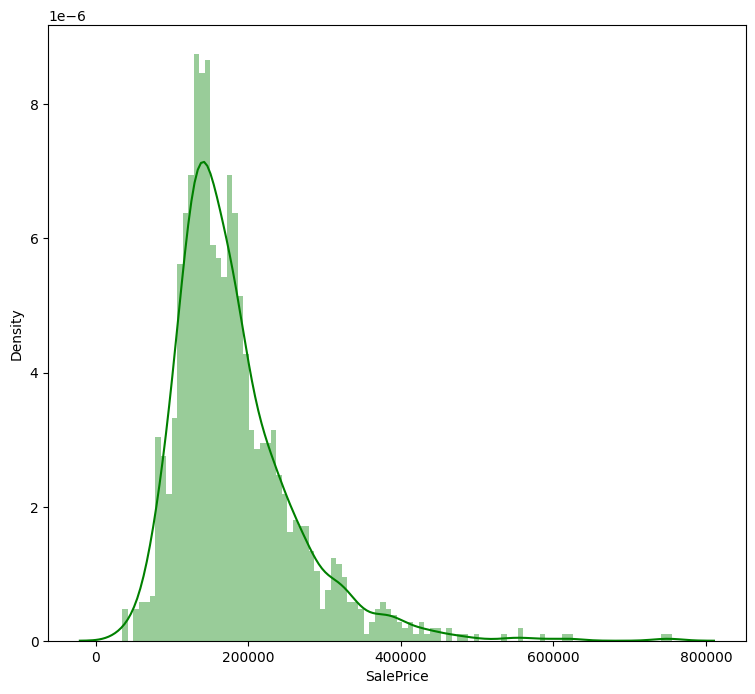

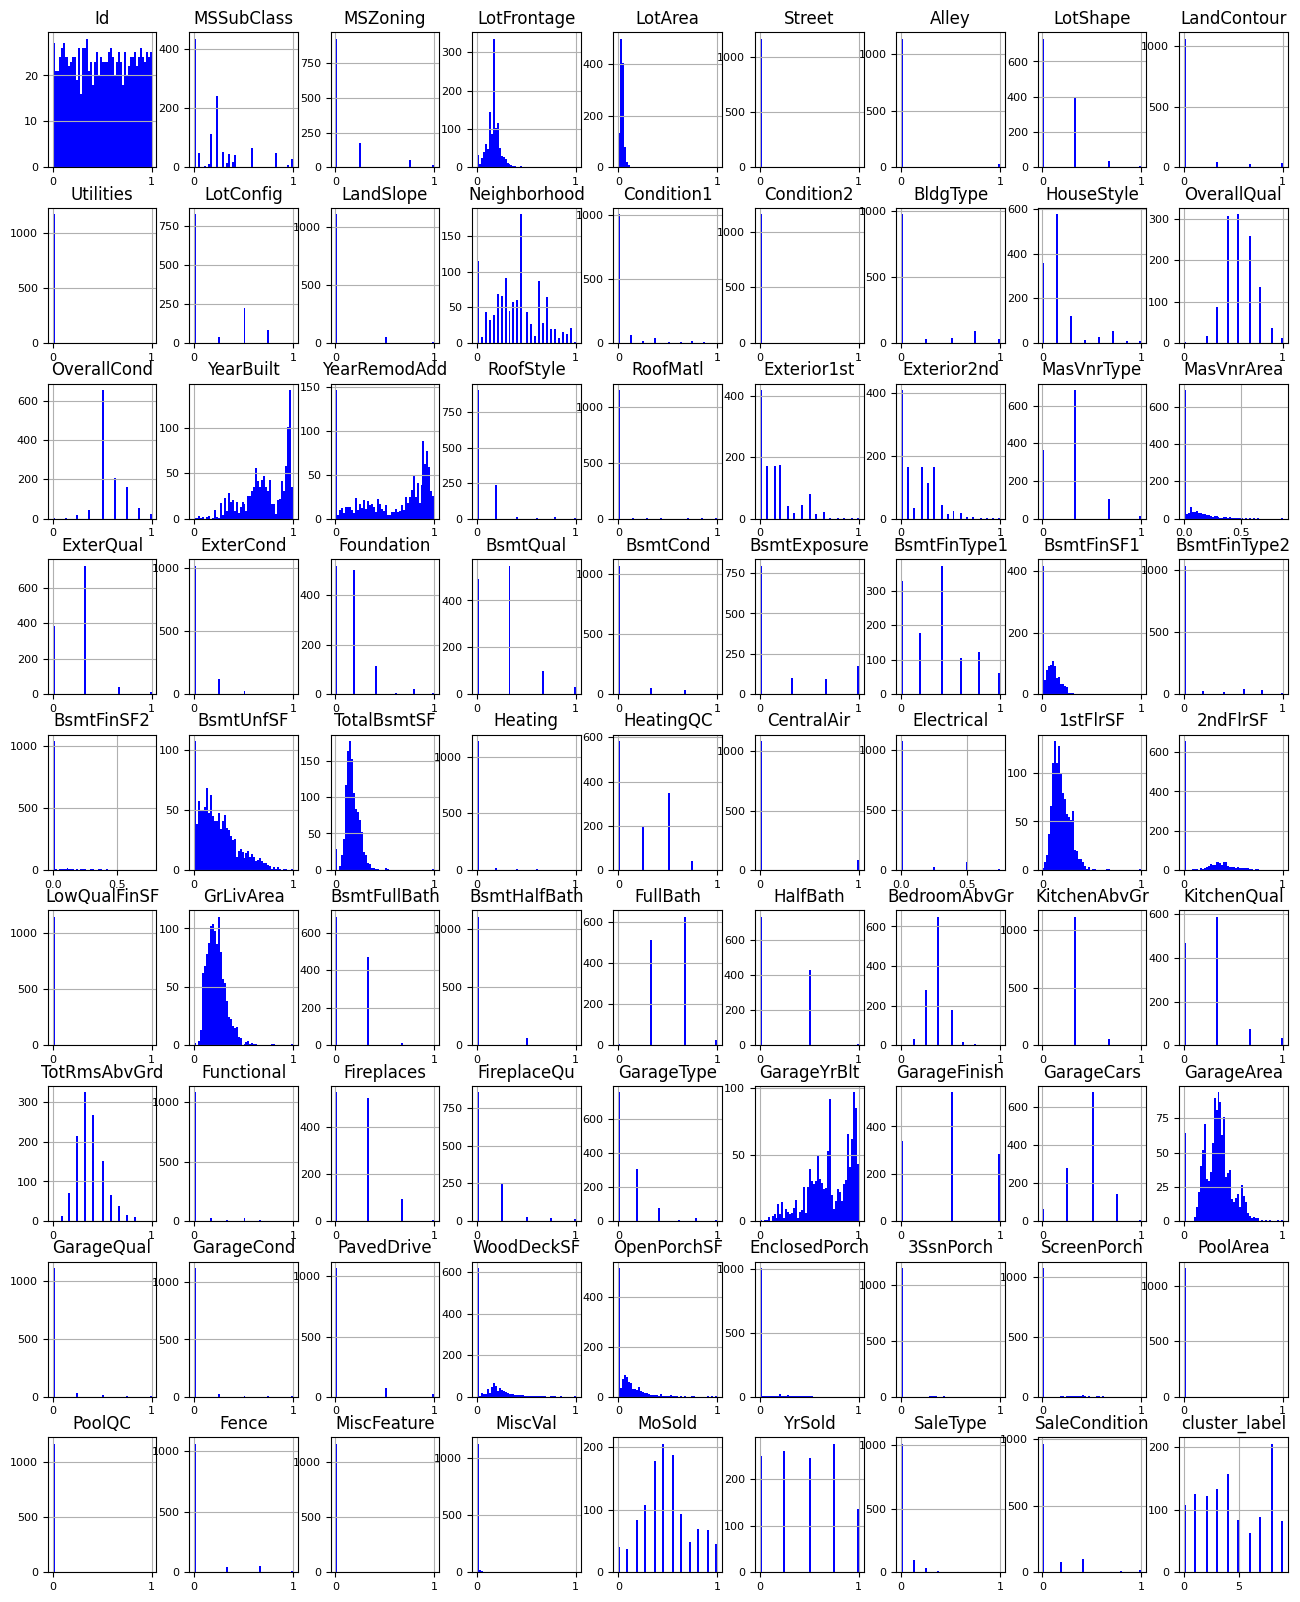

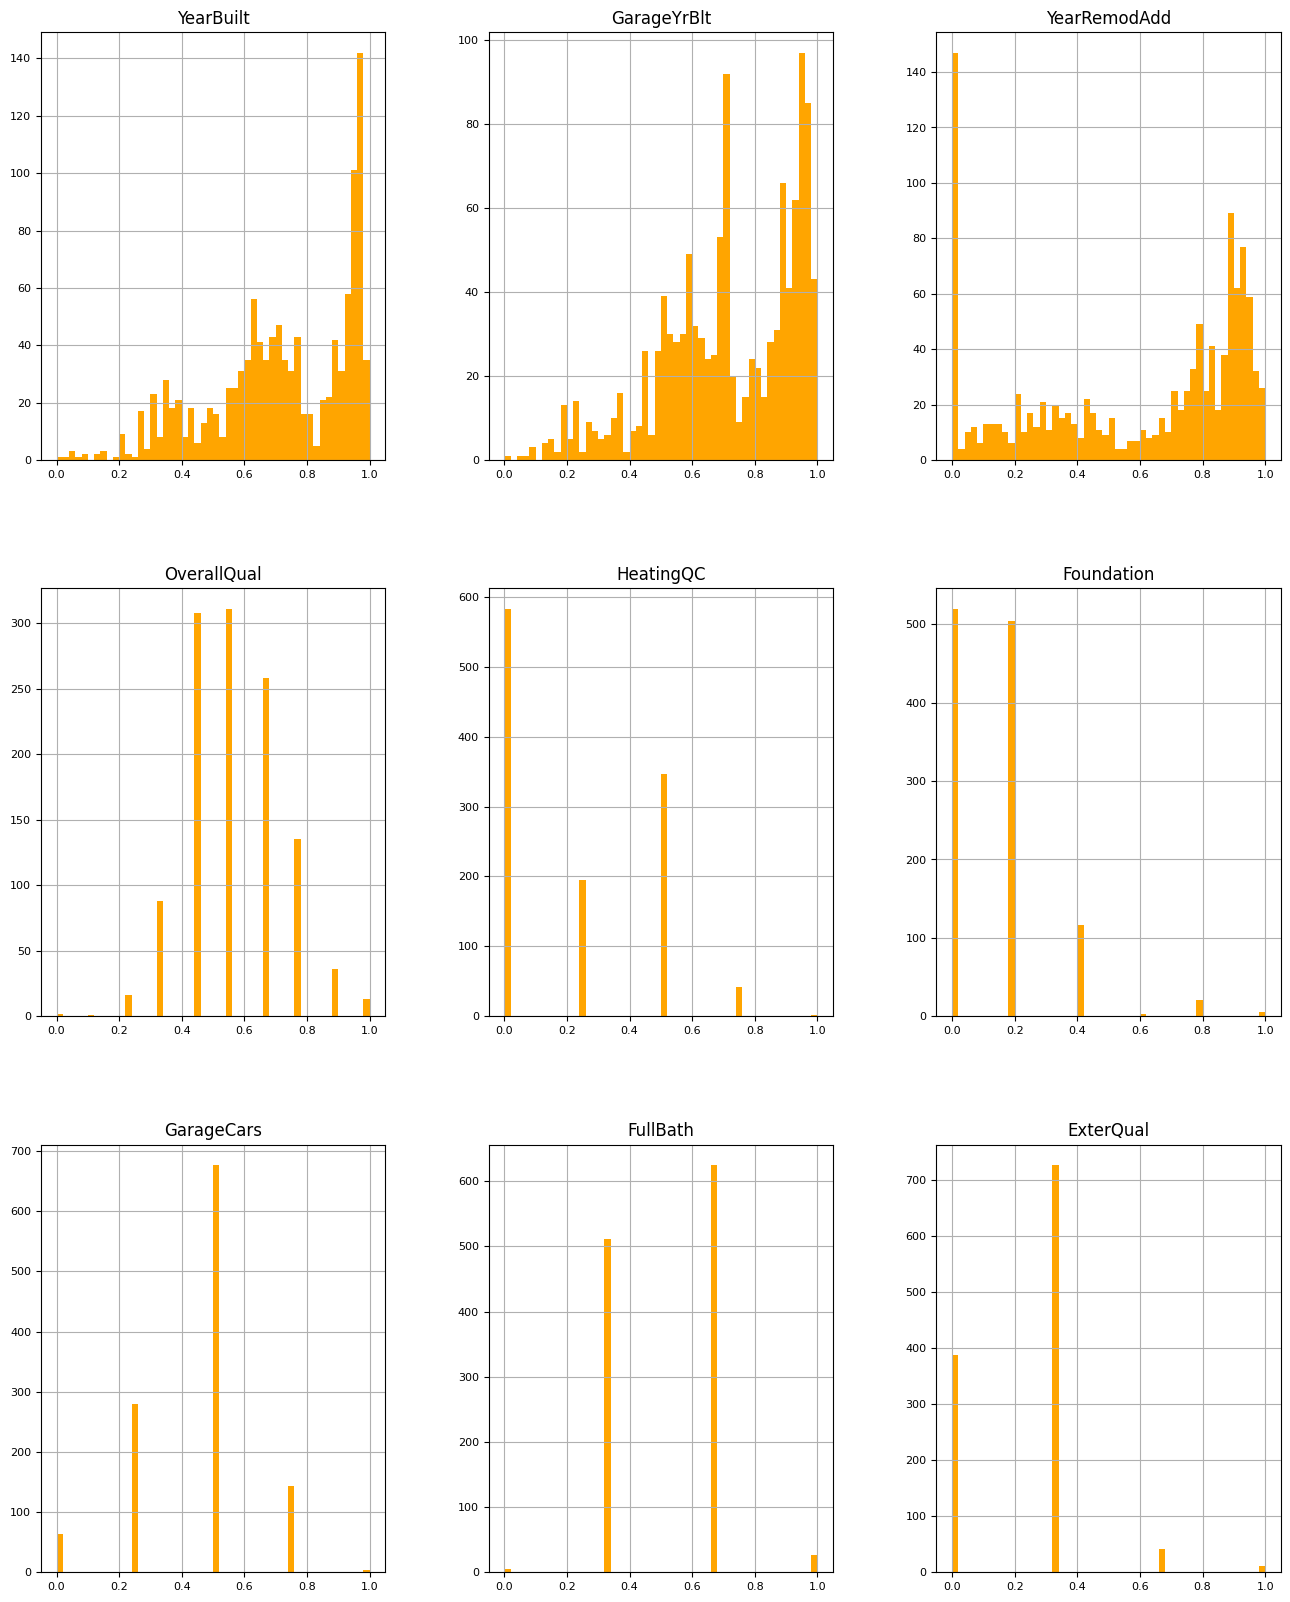

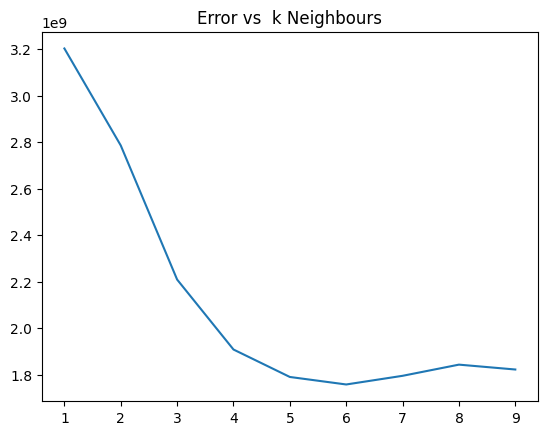

0.7666033033237543

In [15]:
def model():
    full_train, train_result = load_data()
    x_train, x_test, y_train, y_test = normalize(full_train, train_result)
    plot1(train_result)
    new_x_train, new_x_test, top_features_names = cluster(x_train, x_test, 9)
    plot2(x_train, top_features_names)
    return(knn(x_train, y_train, y_test, new_x_train, new_x_test))



model()
